### OpenCV
Goal of this notebook is to become familiar with open CV, and use it to find text regions in an image.

Allow images and plots to be displayed inline, and reload imported modules upon each execution

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cv2 as cv
PATH="/media/ryder/4b16cf63-5c01-4664-9954-fbb9dbaba9d1/MachineLearning/datasets/MSRA-TD500"


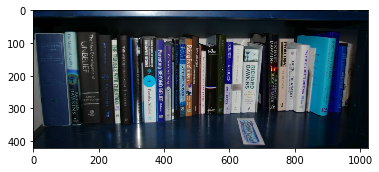

In [3]:
import matplotlib.pyplot as plt 
img = cv.imread(f'{PATH}/train/IMG_0709.JPG')
img = cv.imread(f'{PATH}/../shelf_15-1024x421.jpg')
# print(img)
plt.imshow(img) # can't use open cv's cv.imshow, will crash kernel

Use adaptive threshold to turn the image into black and white blobs.  The goal here is to find outlines of books regardless the lighting conditions, weather some books have dark spines and some bright, etc.  Adaptive threshold applies the threshold function based on a weighted local subset of the image. 

In [4]:
import imutils

threshold = 45
def process(image, threshold):
	resized, rescale_factor = resize(image, 300)
	# convert the resized image to grayscale, blur it slightly,
	# and threshold it
	gray = cv.cvtColor(resized, cv.COLOR_BGR2GRAY)
	blurred = cv.GaussianBlur(gray, (5, 5), 0)
	thresh = cv.adaptiveThreshold(blurred,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,11,2)

	# find contours in the thresholded image and initialize the
	# shape detector
	cnts = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL,
		cv.CHAIN_APPROX_SIMPLE)
	cnts = cnts[0] if imutils.is_cv2() else cnts[1]
	sd = ShapeDetector()

	id = 0
	for c in cnts:
		#print("For contour {}".format(id))
		#print(c)
		id+=1
	cnts_scaled = [[coords[0]*rescale_factor for coords in x] for x in cnts]
	# cnts = [[coords[0] for coords in x] for x in cnts]
	return cnts, cnts_scaled



def resize(image, width):
	width = 300
	resized = imutils.resize(image, width=width)
	ratio = image.shape[0] / float(resized.shape[0])
	return resized, ratio


class ShapeDetector:
	def __init__(self):
		pass

	def detect(self, c):
		peri = cv.arcLength(c, True)
		
		approx = cv.approxPolyDB(c, 1 * peri, True)
		hull = cv.convexHull(cnt)
		print("Perimeter has length " + peri + ", the approximation to this has length " + approx) 
		no_points = len(approx)
		return hull


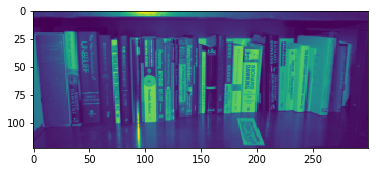

In [5]:
import imutils

resized, rescale_factor = resize(img, 300)
# convert the resized image to grayscale, blur it slightly,
# and threshold it
gray = cv.cvtColor(resized, cv.COLOR_BGR2GRAY)
blurred = cv.GaussianBlur(gray, (5, 5), 0)
thresh = cv.threshold(blurred, threshold, 255, cv.THRESH_BINARY)[1]
thresh2 = cv.adaptiveThreshold(blurred,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,5,3) # must be > 11

plt.imshow(gray)


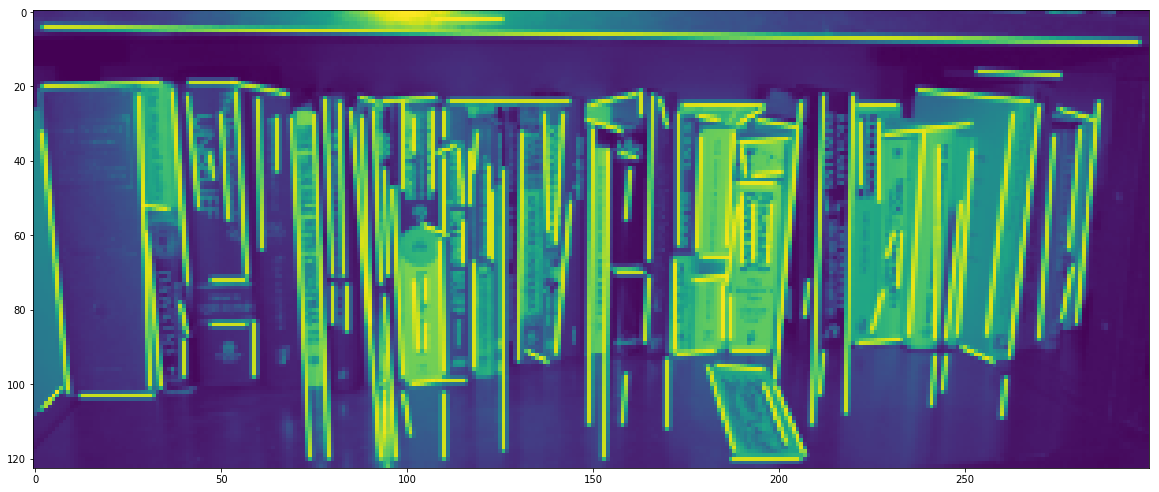

In [169]:
gray_lines = gray.copy()
lsd = cv2.createLineSegmentDetector(0)
dlines = lsd.detect(gray)[0]
for dline in dlines:
    x0 = int(round(dline[0][0]))
    y0 = int(round(dline[0][1]))
    x1 = int(round(dline[0][2]))
    y1 = int(round(dline[0][3]))
    cv2.line(
        gray_lines, (x0, y0), (x1,y1), 255, 1, cv2.LINE_AA)
plt.figure(figsize=(20,20))
plt.imshow(gray_lines)

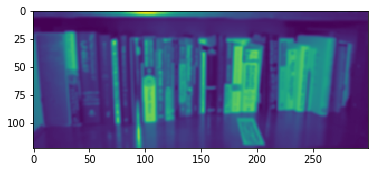

In [6]:
plt.imshow(blurred)

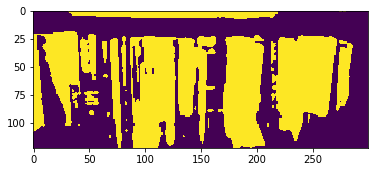

In [7]:
plt.imshow(thresh)

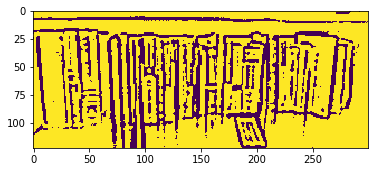

In [8]:
plt.imshow(thresh2)

In [9]:
cnts, cnts_scaled = process(img, 100)

55


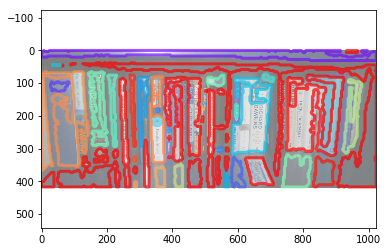

In [10]:
# %matplotlib nbagg 
# allows zooming and panning on image

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
# Circle coordinates (100 points around the circle)
t = np.linspace(0, 2 * np.pi, 100).reshape(100,1)
coords = np.concatenate((np.cos(t), np.sin(t)), axis=1)
plt.imshow(img, alpha=0.5)
ax = plt.axes()

# print(coords)
polygons = [];
for cnt in cnts_scaled:
    polygons.append(Polygon(cnt))
colors = np.random.permutation(plt.cm.rainbow(np.linspace(0, 2, len(cnt))))
p = PatchCollection(polygons, facecolors = ['none'], alpha=0.7,
    edgecolors = colors,
    linewidths = (3,))
ax.add_collection(p)
ax.axis('equal')
print(len(polygons))

Probabilistic Hough Line transform seems to not give the correct lines.  Perhaps there is too much noise been the lines (titles, dark patches on books, etc).

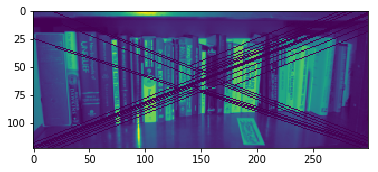

In [11]:
gray_lines = gray.copy()
minLineLength = 80
maxLineGap = 1
lines = cv.HoughLinesP(gray,1,np.pi/380,300,minLineLength,maxLineGap)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv.line(gray_lines,(x1,y1),(x2,y2),(0,255,0),1)
plt.imshow(gray_lines)

Here, we're trying out Canny edge detection.  You can see its challenging to get borders between two books with black spines. Getting the outline of text is good, because it will allow us to count the number of horizontal lines give by the hough transform.  This will be used for our criteria determining whether or not the our line P intersects a title (state $q_6$ below). 

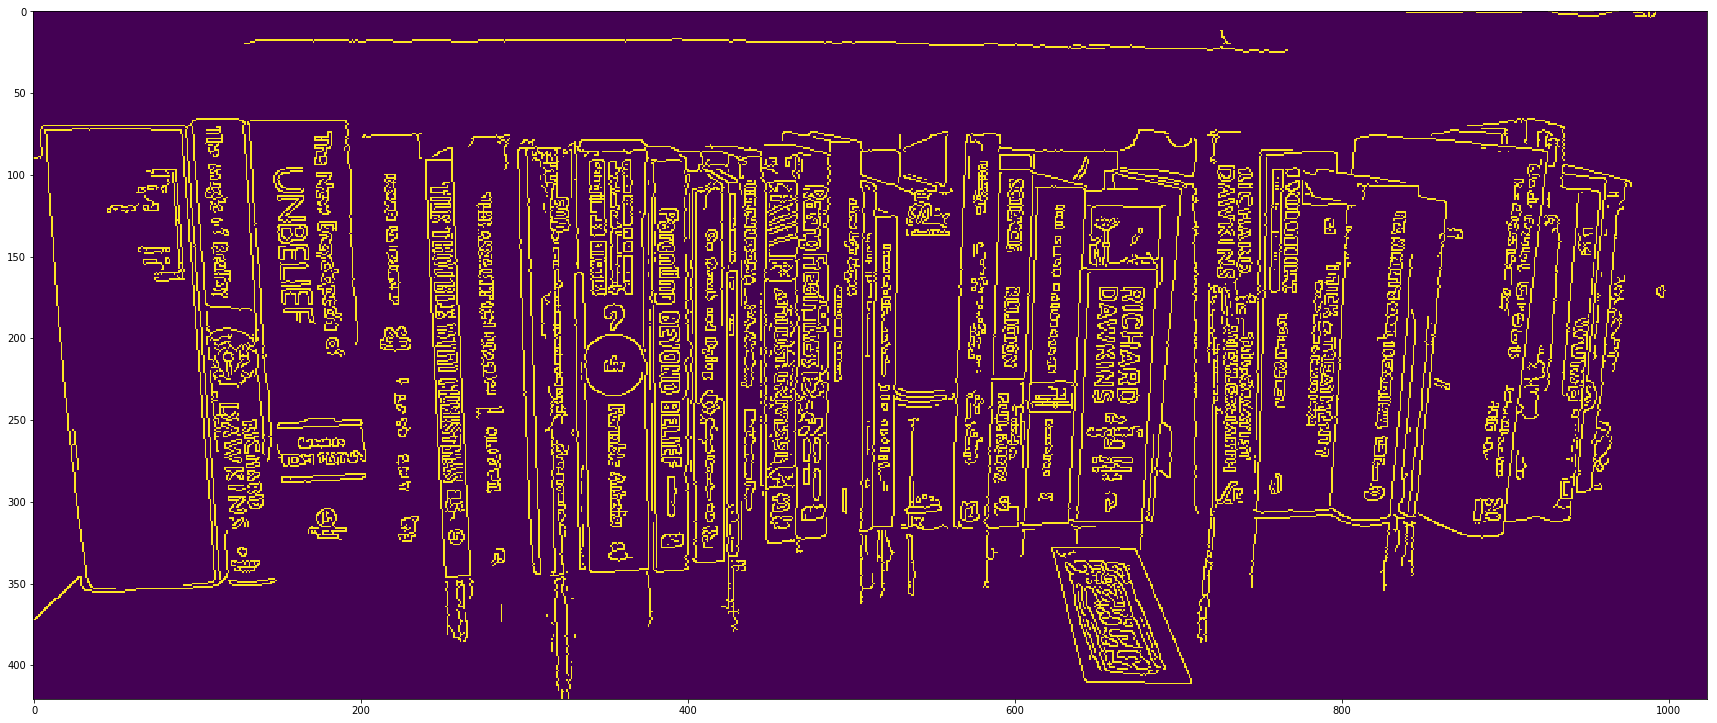

In [124]:
# Try Canny edge detection first
from IPython.display import Image, display
canny_img = cv.Canny(img, 30, 150)
plt.figure(figsize=(30,30))
plt.imshow(canny_img)
# help(plt.imshow)

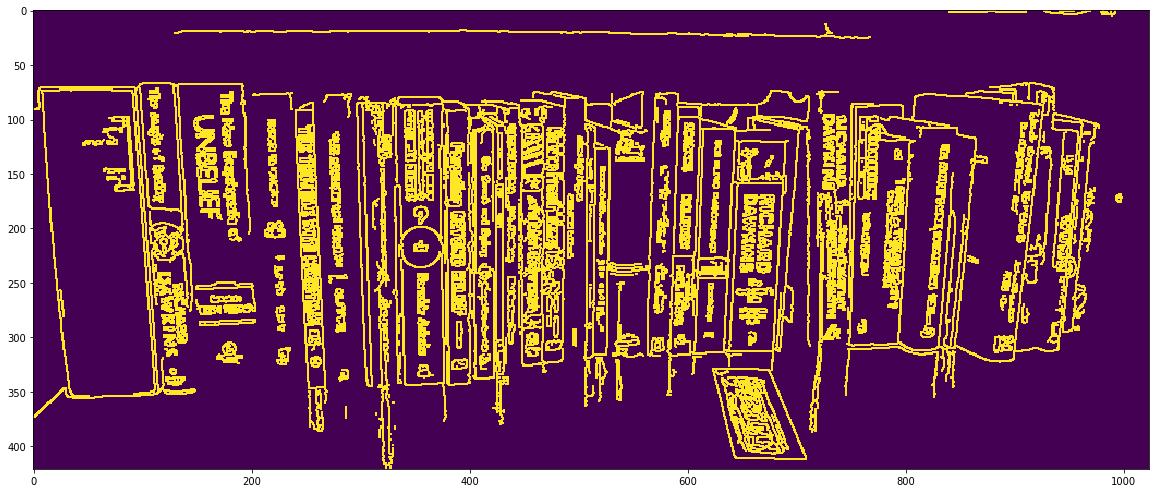

In [139]:
# After dilation
import cv2
import numpy as np

kernel = np.ones((2,2),np.uint8)
canny_img_dilate = cv.dilate(canny_img,kernel,iterations = 1)
plt.figure(figsize=(20,20))
plt.imshow(canny_img_dilate)

HoughLinesP seems to give us fragments of lines which are too short.  Might be an issue w/ the perspective of the camera, since that bends lines a little bit.

/home/ryder/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in int_scalars


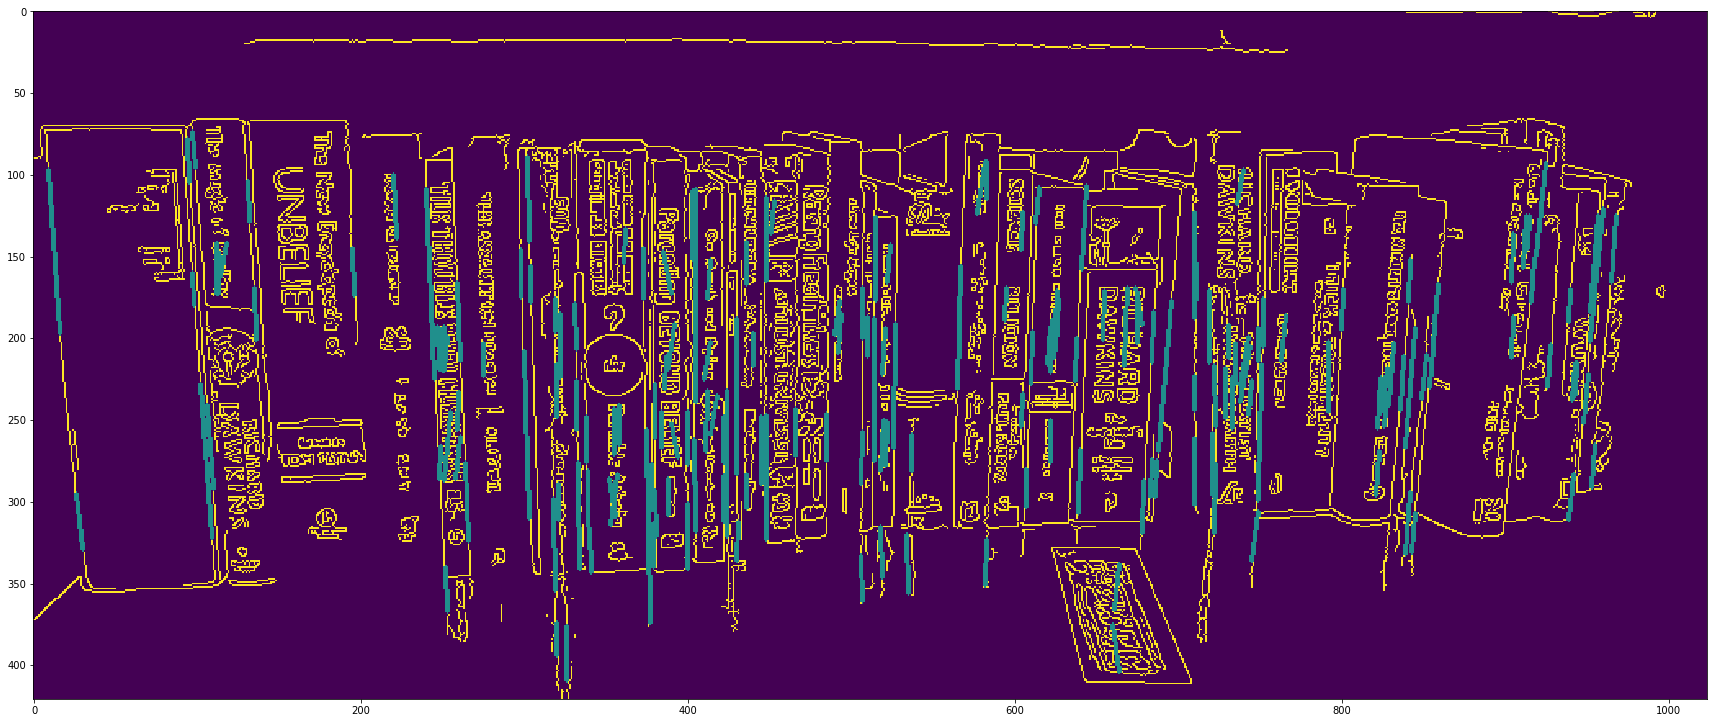

In [156]:
edges = canny_img.copy()
minLineLength = 20
maxLineGap = 3
lines = cv.HoughLinesP(edges,1,np.pi/360,threshold=2,minLineLength=minLineLength,maxLineGap=maxLineGap)
for line in lines:
    for x1,y1,x2,y2 in line:
        if(np.absolute((y1-y2)/(x1-x2)) > 5):
            cv.line(edges,(x1,y1),(x2,y2),(127,23,100),2)
plt.figure(figsize=(30,30))
plt.imshow(edges)

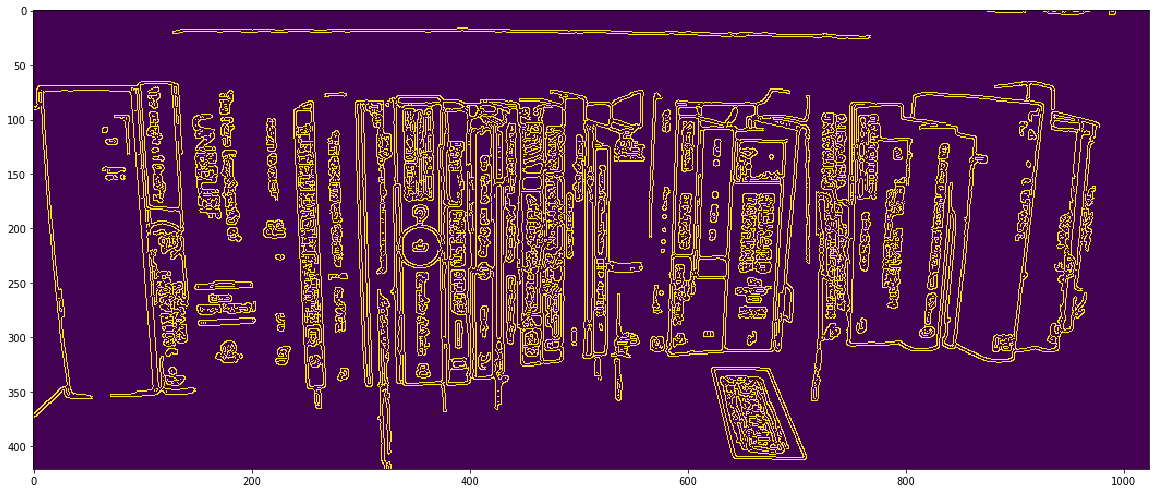

In [65]:
plt.figure(figsize=(20,20))
thicker_canny = cv.Canny(cv.GaussianBlur(canny_img.copy(), (3, 3), 2), 10, 150)
# plt.imshow(cv.GaussianBlur(canny_img.copy(), (3, 3), 5))
plt.imshow(thicker_canny)


Ok, well, this idea didn't really work out better.  Mostly exagerates the horizontal lines in text.

Why don't we group lines that are almost connected & vertical?  Find normal form ($\rho,\theta$) representation first. 

/home/ryder/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in int_scalars


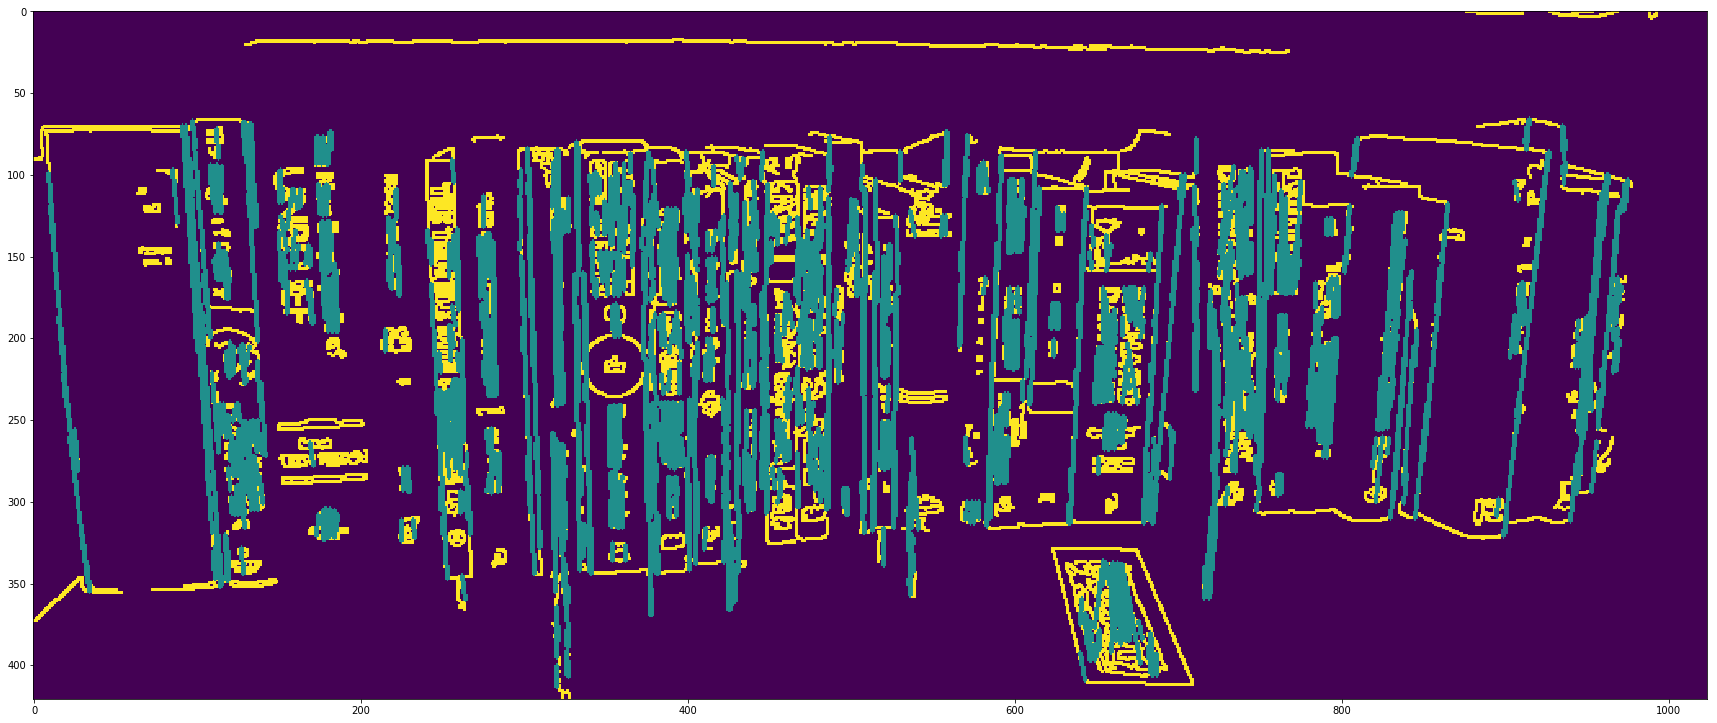

In [128]:
def similar_hough_lines(line1, line2):
    m1 = (line1.y1-line1.y2)/(line1.x1-line1.x2)
    m2 = (line2.y1-line2.y2)/(line2.x1-line2.x2)
    b1 = 0 #
    b2 = 0 #
    normal_vec_cartesian_1 = 0 #
    rho = 0 # 
    theta = 0 #
    return false


edges = canny_img_dilate.copy()
minLineLength = 10
maxLineGap = 2
lines = cv.HoughLinesP(edges,1,np.pi/360,20,minLineLength=minLineLength,maxLineGap=maxLineGap)
for line in lines:
    for x1,y1,x2,y2 in line:
        if(np.absolute((y1-y2)/(x1-x2)) > 5):
            cv.line(edges,(x1,y1),(x2,y2),(127,23,100),2)
plt.figure(figsize=(30,30))
plt.imshow(edges)


Argh!  Distortion seems to be hard to deal with, without having a reference image for calibrating the camera.

Idea: take the shorter segments from the houghlinep segments above, and stitch them together.  After that, filter for the longer ones.

Problem: what if you happen to have a book that's just short?
Answer: maybe its best not to filter the out the medium short ones, because having a  lot of horizontal lines detected will show that it is text.


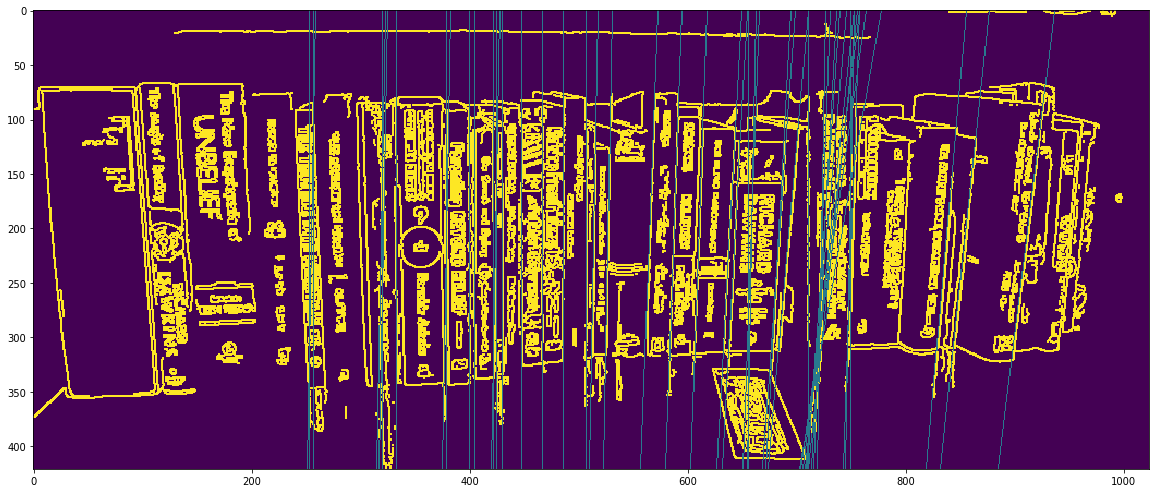

In [151]:
edges = canny_img_dilate.copy()
lines = cv.HoughLines(edges,1,np.pi/180,200)
for line in lines:
    for rho,theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        if(theta > -0.35 and theta < 0.35):
            cv.line(edges,(x1,y1),(x2,y2),(105,20,150),1)
plt.figure(figsize=(20,20))
plt.imshow(edges)

In [ ]:

#Create default parametrization LSD
lsd = cv.createLineSegmentDetector(0)

#Detect lines in the image
lines = lsd.detect(img)

In [ ]:
X, Y = np.meshgrid(np.arange(-3.0,3),np.arange(-3.0,3))


Implementation of the Algorithm in *Book Boundary Detection and Title Extraction for Automatic Bookshelf Inspection* http://human.ait.kyushu-u.ac.jp/~uchida/Papers/fcv2004.pdf

Assumptions:
- image only of a single shelf
- angle of camera is level with and parallel to bookshelf 


1. Create a finite state automation representation of books.
<img src="FSA.jpg">

2. Choose a criteria function that takes the state $s_i$ and position $p_i$ as input.  
<img src="criteria.jpg">


3.  Criteria function will have several parameters associated with it.  Hand label a bunch of images with the best $p_i$'s and $s_i$'s for supervised learning of the parameters of the criteria function $f$.

In [185]:
# What are your data structures?
print(img.shape)

# FSA
q = {}
q[0] = [] # dummy state, so that indices line up with what's in the paper
q[1] = [1,3]  # background
q[2] = [2,1,3]   # right boundary
q[3] = [3,5]     # left boundary
q[4] = [2,4]     # right spine
q[5] = [5,6]     # left spine
q[6] = [6,4,5]   # title


(421, 1024, 3)


In [250]:
# Criterium functions

# Need these functions so we can define each of the f_i functions.
def edges(s,p,i):
    pass

def vertical_features(s,p,i):
    # Idea - count the number of nearly vertical features that nearly intersect the line running between i and p
    # less straightforward because vertical features may contort slightly
    # idea: count total length of the near vertical lines that intersect i and p, and use this as our score
    return 0

def horizontal_features(s,p,i):
    # count the number of horizontal features that intersect the line running between points i and p
    # do this by determining whether there is a solution to the linear system given by both lines
    # iterate over each near horizontal line and count the number of intersections
    return 0

# All criteria functions take 
# s - state at the i-1
# p - the p_{i-1}th pixel
# i - the ith middle pixel

# They return (score, [-1,0,1]), which will be passed to the final
# optimization function later
# set the optimization function to -inf 
# if this state is unobtainable from the previous state

alpha = 1

# Max 2.  If 1 vertical feature, 1.5
def f1(s,p,i):
    if 1 not in q[s]: 
        return float('-inf')
    return 1/(alpha + vertical_features(s,p,i)) + 1/(alpha + horizontal_features(s,p,i))

def f2(s, p,i):
    if 2 not in q[s]: 
        return float('-inf')
    return vertical_features(s,p,i) - horizontal_features(s,p,i)    

def f3(p,i):
    if 3 not in q[s]: 
        return float('-inf')
    return vertical_features(s,p,i) - horizontal_features(s,p,i)    


def f4(p,i):
    if 4 not in q[s]: 
        return float('-inf')
    return horizontal_features(s,p,i)/alpha    


def f5(p,i):
    if 5 not in q[s]: 
        return float('-inf')
    return horizontal_features(s,p,i)/alpha    


def f6(p,i):
    if 6 not in q[s]: 
        return float('-inf')
    return horizontal_features(s,p,i)/(alpha*alpha)    


f = [None,f1, f2, f3, f4, f5, f6]

# Subdividing the middle line of the image into n points, indexed by i
# We iterate through, and assess which of the 6 Q states they belong to
def process(img):
    img_length = img.shape[1]
    n = int(img_length/10)
    g = {}
    bp = {}
    W = int(img.shape[0]*0.005) # W is the maximum slant "angle"
    
    for s in range(1, len(q)):
        print()
        for p in range(1 - W, 1 + W):
            g[(s,p,1)] = f[s](s,p,1)  
    for i in range(2,n):
        for s in range(1, len(q)):
            for p in range(i - W, i + W):
                s_max, p_max = argmax(g,i-1)
#                 print(g)
                g[s,p,i] = f[s](s,p,i) + g[s_max, p_max, i-1]
                bp[s,p,i] = (s_max, p_max, i-1) # stands for ?
    # Backtracking
    optimal_args = {} 
    optimal_args[n-1] = argmax(g,n-1)
#     print(optimal_args)
#     print(bp)
    for i in reversed(range(2,n)):
#         print(i)
        optimal_args[i - 1] = bp[optimal_args[i][0], optimal_args[i][1], i]
    return optimal_args

def argmax(g,i):
    s_max = 1
    p_max = 0
    max_g = float('-inf') # assume
    # get all keys available for index i
    keys_i = [k for k,v in g.items() if k[2] == i]
    for args in keys_i:
        if g[args] >= max_g:
            s_max, p_max, _ = args
            max_g = g[args]
    return s_max, p_max

g = process(img)
g
# Why are we getting the last state 6 as the optimum when the score function always rewards state 4?


{1: (5, 2, 1),
 2: (5, 3, 2),
 3: (5, 4, 3),
 4: (5, 5, 4),
 5: (5, 6, 5),
 6: (5, 7, 6),
 7: (5, 8, 7),
 8: (5, 9, 8),
 9: (5, 10, 9),
 10: (5, 11, 10),
 11: (5, 12, 11),
 12: (5, 13, 12),
 13: (5, 14, 13),
 14: (5, 15, 14),
 15: (5, 16, 15),
 16: (5, 17, 16),
 17: (5, 18, 17),
 18: (5, 19, 18),
 19: (5, 20, 19),
 20: (5, 21, 20),
 21: (5, 22, 21),
 22: (5, 23, 22),
 23: (5, 24, 23),
 24: (5, 25, 24),
 25: (5, 26, 25),
 26: (5, 27, 26),
 27: (5, 28, 27),
 28: (5, 29, 28),
 29: (5, 30, 29),
 30: (5, 31, 30),
 31: (5, 32, 31),
 32: (5, 33, 32),
 33: (5, 34, 33),
 34: (5, 35, 34),
 35: (5, 36, 35),
 36: (5, 37, 36),
 37: (5, 38, 37),
 38: (5, 39, 38),
 39: (5, 40, 39),
 40: (5, 41, 40),
 41: (5, 42, 41),
 42: (5, 43, 42),
 43: (5, 44, 43),
 44: (5, 45, 44),
 45: (5, 46, 45),
 46: (5, 47, 46),
 47: (5, 48, 47),
 48: (5, 49, 48),
 49: (5, 50, 49),
 50: (5, 51, 50),
 51: (5, 52, 51),
 52: (5, 53, 52),
 53: (5, 54, 53),
 54: (5, 55, 54),
 55: (5, 56, 55),
 56: (5, 57, 56),
 57: (5, 58, 57),


In [236]:
g = {}
for i in range(0,10):
    for j in range(0,5):
        for k in range(0,2):
            g[i,j,k] = (i,j,k)
            
a,b,c = g[(0,0,0)]
            
b
[None,1,2,3]

optimate_d = []
# optimate_d[0] = 3

for i in reversed(range(0,2)):
    print(i)

1
0
